**Script Description:** This script extracts all three OWASIS variables from the TIFF files and exports the data as CSV files. 

**File Name:** 01_07_Extract_OWASIS_Data.ipynb

**Date:** 2025

**Created by:** Rob Alamgir

#### Import the relevant packages

In [16]:
import os
import glob
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from rasterio.transform import rowcol
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

#### Import the relevant data files

In [2]:
data_dir = "C:/Data_MSc_Thesis/OWASIS/OWASIS_friesland_data"                       # Set directories
raster_files = sorted(glob.glob(os.path.join(data_dir, "friesland_20*", "*.tif"))) # Get list of OWASIS raster files

point_data_path = "C:/Data_MSc_Thesis/NOBV_Site_Data/NOBV_EC_Tower_Data_Final.csv"
point_data = pd.read_csv(point_data_path)                                          # Load and preprocess the point data

#### Pre-process the datasets

In [3]:
point_data.rename(columns={"EPSG_4326_WGS_84_Longitude_X": "Longitude",
                           "EPSG_4326_WGS_84_Latitude_Y": "Latitude"}, inplace=True)

# Convert to GeoDataFrame and reproject
gdf = gpd.GeoDataFrame(point_data, geometry=gpd.points_from_xy(point_data.Longitude, point_data.Latitude), crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:28992")  # Reproject to match raster CRS (EPSG:28992)

# Extract reprojected coordinates
gdf["Reproj_X"] = gdf.geometry.x
gdf["Reproj_Y"] = gdf.geometry.y

gdf.info()
#gdf.head(12)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Site_no                21 non-null     int64   
 1   Location_No            21 non-null     int64   
 2   Site_ID                21 non-null     object  
 3   Longitude              21 non-null     float64 
 4   Latitude               21 non-null     float64 
 5   EPSG_32631_WGS 84_X_m  21 non-null     float64 
 6   EPSG_32631_WGS 84_Y_m  21 non-null     float64 
 7   Elevation_m            21 non-null     float64 
 8   geometry               21 non-null     geometry
 9   Reproj_X               21 non-null     float64 
 10  Reproj_Y               21 non-null     float64 
dtypes: float64(7), geometry(1), int64(2), object(1)
memory usage: 1.9+ KB


#### Loop through each raster file and extract values

In [4]:
extracted_data = {}                          # Create empty DataFrame for results

for raster_file in raster_files:
    with rasterio.open(raster_file) as src:
        affine = src.transform
        band = src.read(1)                   # Read the first band
        
        # Extract date from file name
        file_name = os.path.basename(raster_file)
        date_str = file_name.split("_")[-2]                  # Extracts '2020-01-01T00h00m00s'
        date = datetime.strptime(date_str[:10], "%Y-%m-%d")  # Convert to Date format

        # Determine raster type based on filename
        if "Grondwaterstand" in file_name:
            var_name = "Grondwaterstand"
        elif "Bodemvocht" in file_name:
            var_name = "Bodemvocht"
        elif "Beschikbare.Bodemberging" in file_name:
            var_name = "Beschikbare.Bodemberging"
        else:
            continue  # Skip files that don't match any variable

        # Extract values for all sites
        for _, row in gdf.iterrows():
            x, y = row["Reproj_X"], row["Reproj_Y"]
            row_idx, col_idx = ~affine * (x, y)                          # Convert world coords to raster indices
            row_idx, col_idx = int(round(row_idx)), int(round(col_idx))  # Ensure integer indices

            # Extract pixel value if inside bounds
            value = None
            if (0 <= row_idx < band.shape[0]) and (0 <= col_idx < band.shape[1]):
                value = band[row_idx, col_idx]

            # Store data
            key = (date, row["Site_ID"])
            if key not in extracted_data:
                extracted_data[key] = {"Datetime": date, "Site_ID": row["Site_ID"]}
            extracted_data[key][var_name] = value

df_extracted = pd.DataFrame.from_dict(extracted_data, orient="index")   # Convert dictionary to DataFrame

In [5]:
df_extracted.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 26250 entries, (Timestamp('2020-01-01 00:00:00'), 'ALB_MS') to (Timestamp('2023-06-06 00:00:00'), 'ZEG_PT')
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Datetime                  26250 non-null  datetime64[ns]
 1   Site_ID                   26250 non-null  object        
 2   Beschikbare.Bodemberging  12500 non-null  float64       
 3   Bodemvocht                12500 non-null  float64       
 4   Grondwaterstand           12500 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.1+ MB


In [6]:
df_extracted.head(30)

Datetime  Site_ID  Beschikbare.Bodemberging  Bodemvocht  \
2020-01-01 ALB_MS  2020-01-01   ALB_MS                 62.537395  138.342163   
           ALB_RF  2020-01-01   ALB_RF                 33.239799   78.519531   
           AMM     2020-01-01      AMM                 76.076241   80.411850   
           AMR     2020-01-01      AMR                 50.945713   32.152786   
           ANK_PT  2020-01-01   ANK_PT                       NaN         NaN   
           ASD_MP  2020-01-01   ASD_MP                       NaN         NaN   
           BUO     2020-01-01      BUO                  8.431787  126.277924   
           BUW     2020-01-01      BUW                  7.907817  123.345016   
           CAM     2020-01-01      CAM                       NaN         NaN   
           DEM     2020-01-01      DEM                       NaN         NaN   
           HOC     2020-01-01      HOC                  0.000000  119.303215   
           HOH     2020-01-01      HOH                  1.225705  132.776093   
           ILP_PT  2020-01-01   ILP_PT                       NaN         NaN   
           LAW_MOB 2020-01-01  LAW_MOB                       NaN         NaN   
           LAW_MS  2020-01-01   LAW_MS                       NaN         NaN   
           LDC     2020-01-01      LDC                 81.302261   15.181621   
           LDH     2020-01-01      LDH                 80.889481  277.487335   
           ONL     2020-01-01      ONL                       NaN         NaN   
           WRW_SR  2020-01-01   WRW_SR                       NaN         NaN   
           ZEG_MOB 2020-01-01  ZEG_MOB                       NaN         NaN   
           ZEG_PT  2020-01-01   ZEG_PT                       NaN         NaN   
2020-01-02 ALB_MS  2020-01-02   ALB_MS                 64.082191  137.991455   
           ALB_RF  2020-01-02   ALB_RF                 34.155682   78.291588   
           AMM     2020-01-02      AMM                 77.138756   80.219078   
           AMR     2020-01-02      AMR                 52.032490   32.152790   
           ANK_PT  2020-01-02   ANK_PT                       NaN         NaN   
           ASD_MP  2020-01-02   ASD_MP                       NaN         NaN   
           BUO     2020-01-02      BUO                  8.791737  126.207916   
           BUW     2020-01-02      BUW                  8.174280  123.297791   
           CAM     2020-01-02      CAM                       NaN         NaN   

                    Grondwaterstand  
2020-01-01 ALB_MS         -2.016973  
           ALB_RF         -1.885893  
           AMM            -1.438467  
           AMR            -1.509918  
           ANK_PT               NaN  
           ASD_MP               NaN  
           BUO            -1.378846  
           BUW            -1.455931  
           CAM                  NaN  
           DEM                  NaN  
           HOC            -0.420185  
           HOH            -0.578996  
           ILP_PT               NaN  
           LAW_MOB              NaN  
           LAW_MS               NaN  
           LDC            -0.576512  
           LDH            -0.508653  
           ONL                  NaN  
           WRW_SR               NaN  
           ZEG_MOB              NaN  
           ZEG_PT               NaN  
2020-01-02 ALB_MS         -2.021312  
           ALB_RF         -1.893311  
           AMM            -1.446269  
           AMR            -1.513176  
           ANK_PT               NaN  
           ASD_MP               NaN  
           BUO            -1.388076  
           BUW            -1.462792  
           CAM                  NaN

In [7]:
#df_extracted.info()
df_extracted.tail(30)

Datetime  Site_ID  Beschikbare.Bodemberging  Bodemvocht  \
2023-06-05 ILP_PT  2023-06-05   ILP_PT                       NaN         NaN   
           LAW_MOB 2023-06-05  LAW_MOB                       NaN         NaN   
           LAW_MS  2023-06-05   LAW_MS                       NaN         NaN   
           LDC     2023-06-05      LDC                191.202515   61.739803   
           LDH     2023-06-05      LDH                208.840546  166.308105   
           ONL     2023-06-05      ONL                       NaN         NaN   
           WRW_SR  2023-06-05   WRW_SR                       NaN         NaN   
           ZEG_MOB 2023-06-05  ZEG_MOB                       NaN         NaN   
           ZEG_PT  2023-06-05   ZEG_PT                       NaN         NaN   
2023-06-06 ALB_MS  2023-06-06   ALB_MS                148.118866  169.232635   
           ALB_RF  2023-06-06   ALB_RF                 80.538330  102.187294   
           AMM     2023-06-06      AMM                128.110825   93.695625   
           AMR     2023-06-06      AMR                122.625381  210.950165   
           ANK_PT  2023-06-06   ANK_PT                       NaN         NaN   
           ASD_MP  2023-06-06   ASD_MP                       NaN         NaN   
           BUO     2023-06-06      BUO                 78.265373  118.869431   
           BUW     2023-06-06      BUW                 81.777657  119.501472   
           CAM     2023-06-06      CAM                       NaN         NaN   
           DEM     2023-06-06      DEM                       NaN         NaN   
           HOC     2023-06-06      HOC                 47.617195   86.110695   
           HOH     2023-06-06      HOH                  4.318503  129.683304   
           ILP_PT  2023-06-06   ILP_PT                       NaN         NaN   
           LAW_MOB 2023-06-06  LAW_MOB                       NaN         NaN   
           LAW_MS  2023-06-06   LAW_MS                       NaN         NaN   
           LDC     2023-06-06      LDC                194.148682   59.638859   
           LDH     2023-06-06      LDH                211.638580  163.769135   
           ONL     2023-06-06      ONL                       NaN         NaN   
           WRW_SR  2023-06-06   WRW_SR                       NaN         NaN   
           ZEG_MOB 2023-06-06  ZEG_MOB                       NaN         NaN   
           ZEG_PT  2023-06-06   ZEG_PT                       NaN         NaN   

                    Grondwaterstand  
2023-06-05 ILP_PT               NaN  
           LAW_MOB              NaN  
           LAW_MS               NaN  
           LDC            -1.011724  
           LDH            -0.972347  
           ONL                  NaN  
           WRW_SR               NaN  
           ZEG_MOB              NaN  
           ZEG_PT               NaN  
2023-06-06 ALB_MS         -2.153658  
           ALB_RF         -2.137708  
           AMM            -1.723945  
           AMR            -1.718699  
           ANK_PT               NaN  
           ASD_MP               NaN  
           BUO            -1.924563  
           BUW            -2.036341  
           CAM                  NaN  
           DEM                  NaN  
           HOC            -1.061931  
           HOH            -0.721961  
           ILP_PT               NaN  
           LAW_MOB              NaN  
           LAW_MS               NaN  
           LDC            -1.015984  
           LDH            -0.976084  
           ONL                  NaN  
           WRW_SR               NaN  
           ZEG_MOB              NaN  
           ZEG_PT               NaN

#### Post-process the final dataframe 

In [8]:
df_extracted.rename(columns={
    "Bodemvocht": "RZSM_OWASIS",
    "Grondwaterstand": "GWL_OWASIS",
    "Beschikbare.Bodemberging": "AWS_OWASIS"}, inplace=True)

# Reset index if it's a MultiIndex
if isinstance(df_extracted.index, pd.MultiIndex):
    df_extracted.reset_index(inplace=True)

df_extracted = df_extracted[["Datetime", "Site_ID", "RZSM_OWASIS", "GWL_OWASIS", "AWS_OWASIS"]]

In [10]:
df_extracted.info()
df_extracted.head(30)
#df_extracted.tail(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26250 entries, 0 to 26249
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Datetime     26250 non-null  datetime64[ns]
 1   Site_ID      26250 non-null  object        
 2   RZSM_OWASIS  12500 non-null  float64       
 3   GWL_OWASIS   12500 non-null  float64       
 4   AWS_OWASIS   12500 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 1.0+ MB


,Datetime,Site_ID,RZSM_OWASIS,GWL_OWASIS,AWS_OWASIS
0,2020-01-01,ALB_MS,138.342163,-2.016973,62.537395
1,2020-01-01,ALB_RF,78.519531,-1.885893,33.239799
2,2020-01-01,AMM,80.411850,-1.438467,76.076241
3,2020-01-01,AMR,32.152786,-1.509918,50.945713
4,2020-01-01,ANK_PT,NaN,NaN,NaN
5,2020-01-01,ASD_MP,NaN,NaN,NaN
6,2020-01-01,BUO,126.277924,-1.378846,8.431787
7,2020-01-01,BUW,123.345016,-1.455931,7.907817
8,2020-01-01,CAM,NaN,NaN,NaN
9,2020-01-01,DEM,NaN,NaN,NaN


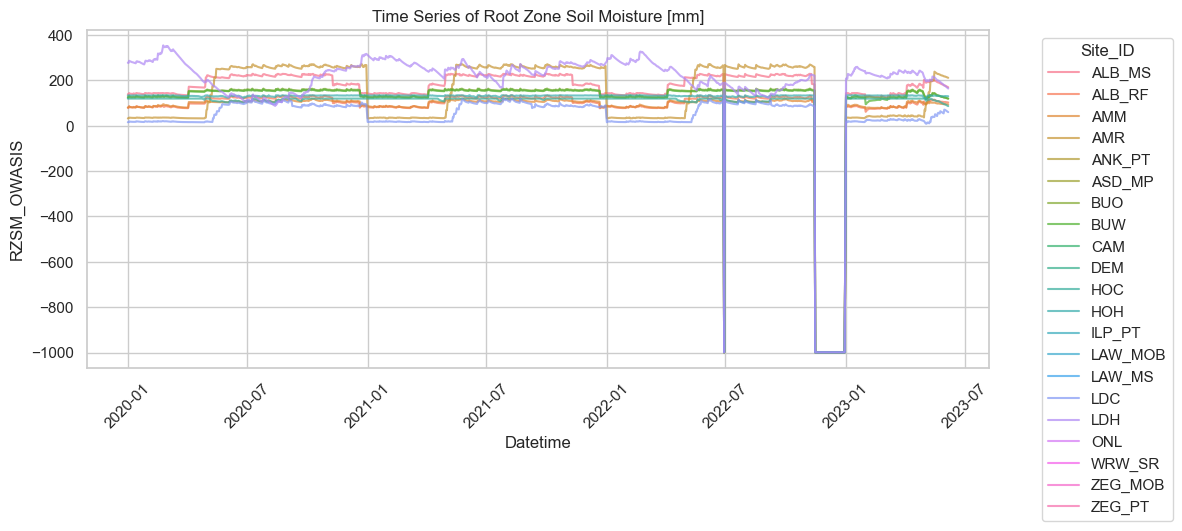

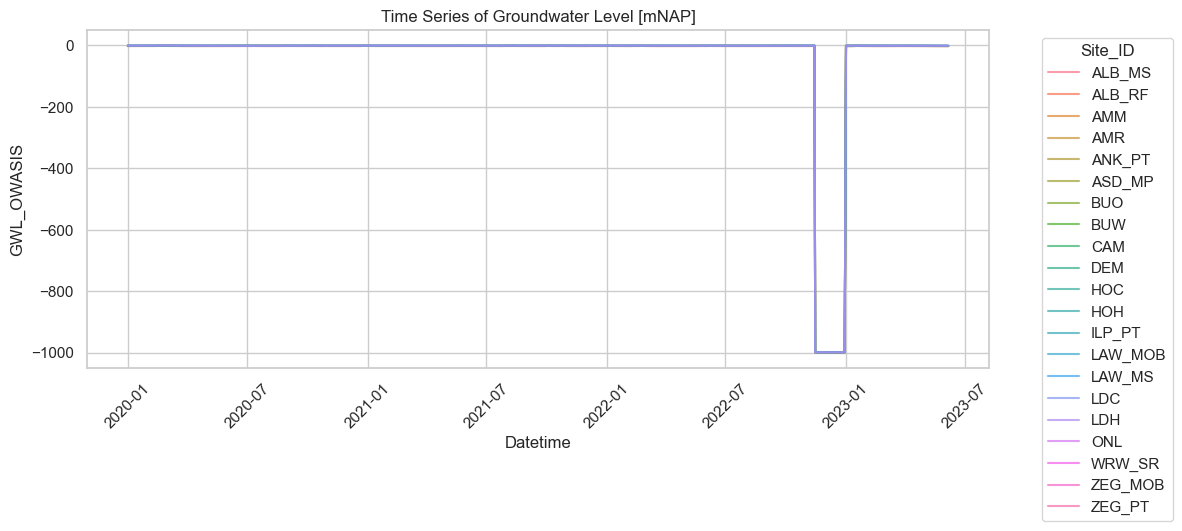

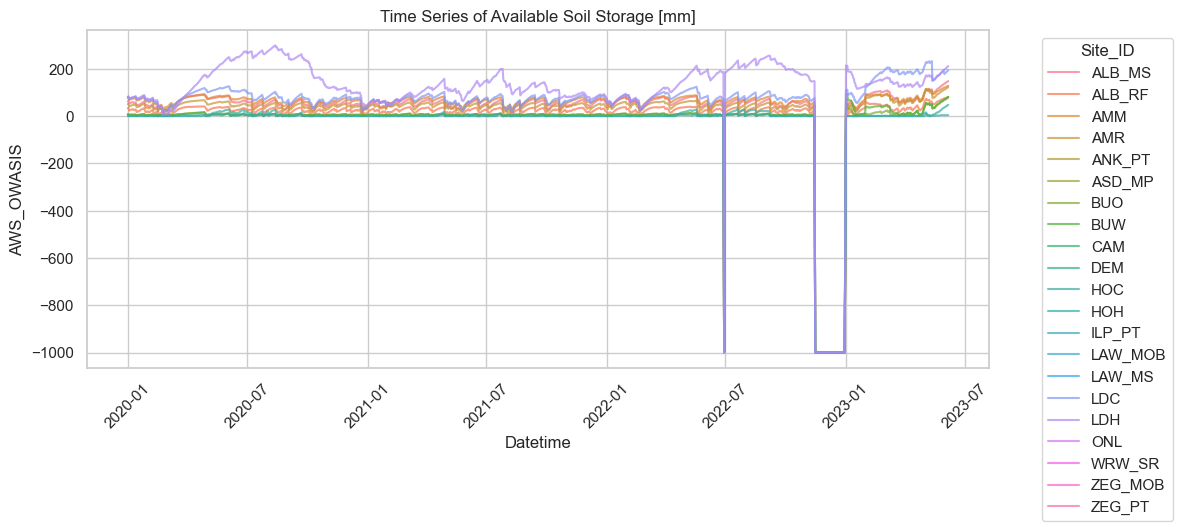

In [14]:
sns.set_theme(style="whitegrid")  # Set plot style

variables = {
    "RZSM_OWASIS": "Time Series of Root Zone Soil Moisture [mm]",
    "GWL_OWASIS": "Time Series of Groundwater Level [mNAP]",
    "AWS_OWASIS": "Time Series of Available Soil Storage [mm]"}

for var, title in variables.items():
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_extracted, x="Datetime", y=var, hue="Site_ID", alpha=0.7)
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.legend(title="Site_ID", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
    plt.tight_layout()
    plt.show()

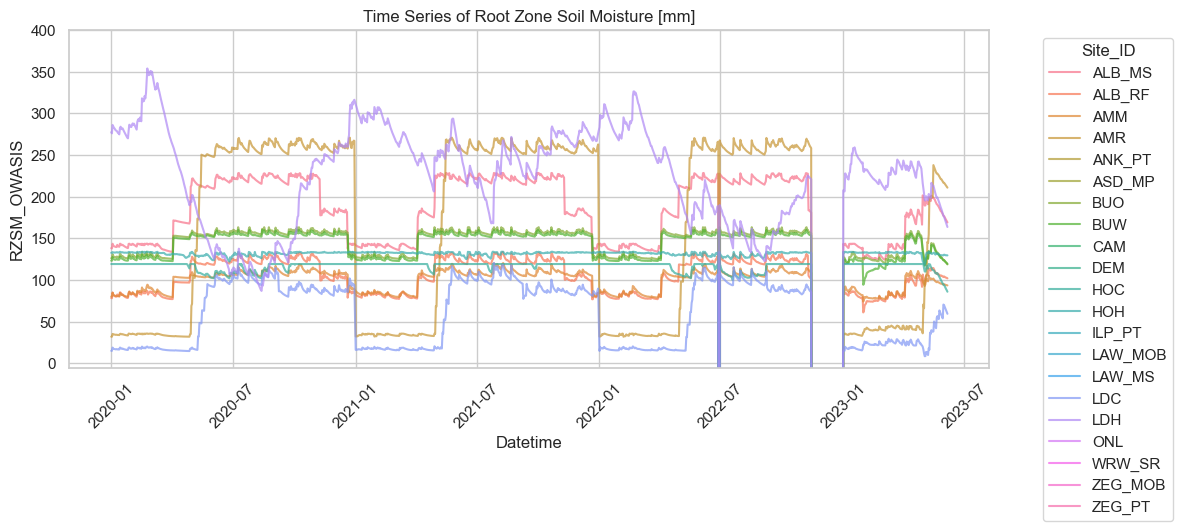

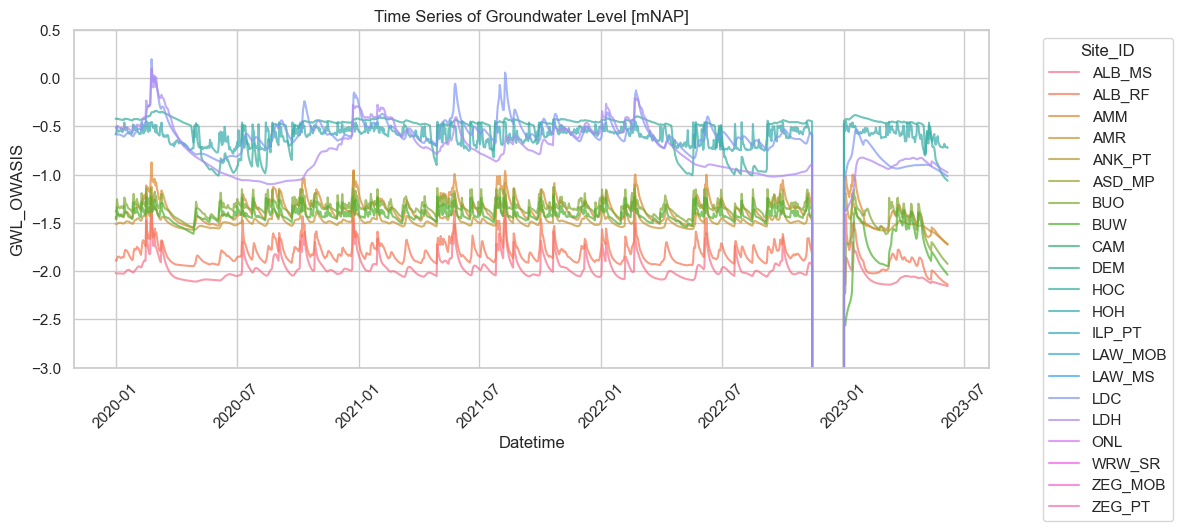

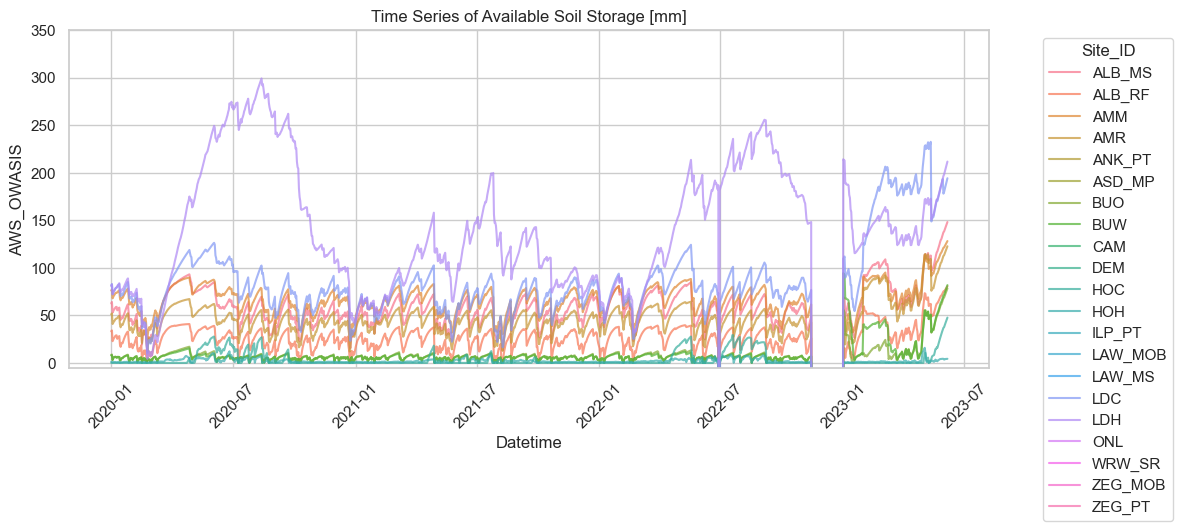

In [15]:
sns.set_theme(style="whitegrid")   # Set plot style

plot_configs = {"RZSM_OWASIS": {"title": "Time Series of Root Zone Soil Moisture [mm]",
                                         "ymin": -5, "ymax": 400 },
                "GWL_OWASIS": {"title": "Time Series of Groundwater Level [mNAP]",
                                             "ymin": -3, "ymax": 0.5 },
                "AWS_OWASIS": {"title": "Time Series of Available Soil Storage [mm]",
                                                  "ymin": -5, "ymax": 350}}

for var, config in plot_configs.items():
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_extracted, x="Datetime", y=var, hue="Site_ID", alpha=0.7)
    plt.title(config["title"])
    plt.xlabel("Datetime")
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.ylim(config["ymin"], config["ymax"])   # Manually set y-axis limits
    plt.legend(title="Site_ID", bbox_to_anchor=(1.05, 1), loc="upper left")  
    plt.tight_layout()
    plt.show()

#### Clean the dataframe to exclude values which are clearly anomalies

In [20]:
# Define valid ranges for each variable
valid_ranges = {"RZSM_OWASIS": (-5, 400),
                "GWL_OWASIS": (-3, 0.5),
                "AWS_OWASIS": (-5, 350)}

# Replace out-of-range values with NaN
for var, (ymin, ymax) in valid_ranges.items():
    df_extracted[var] = np.where(
        (df_extracted[var] < ymin) | (df_extracted[var] > ymax),
        np.nan,
        df_extracted[var]
    )

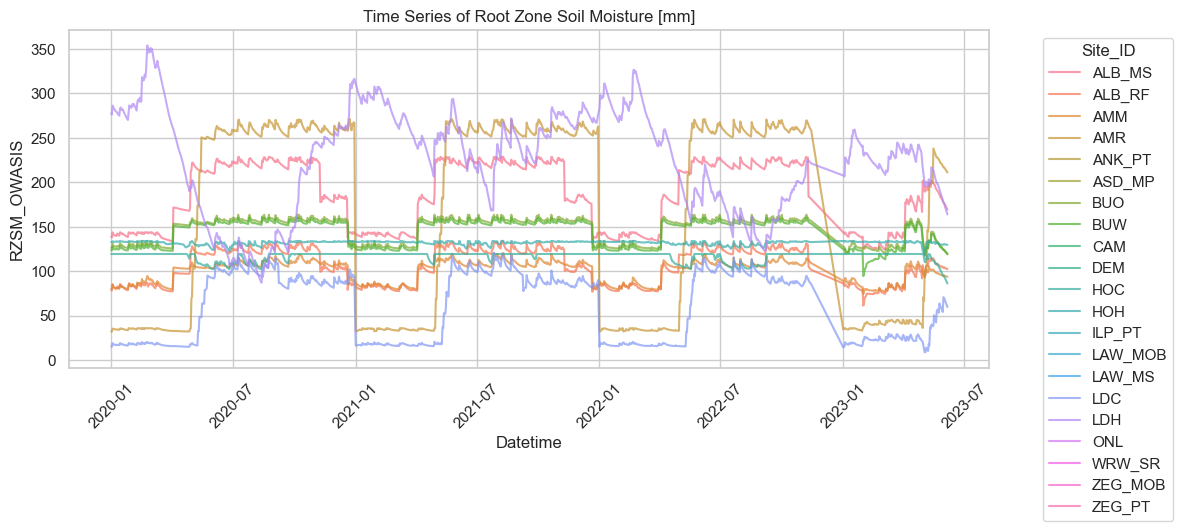

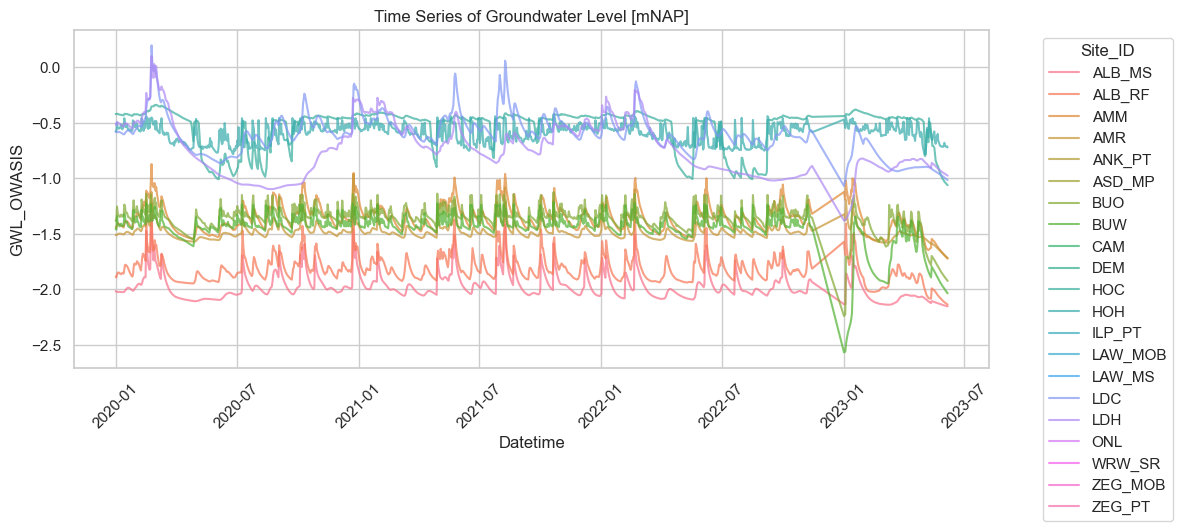

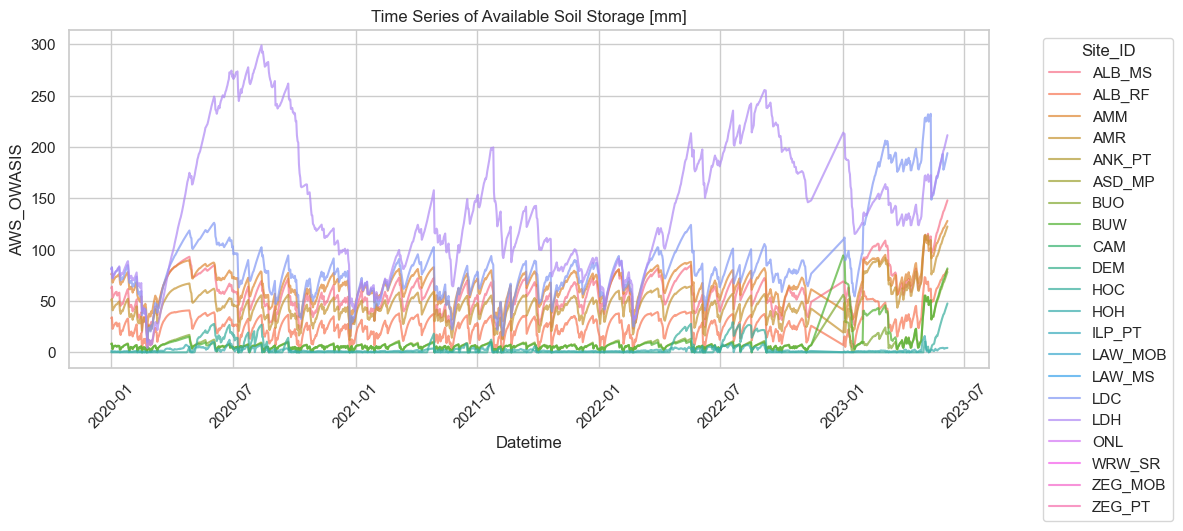

In [21]:
sns.set_theme(style="whitegrid")  # Set plot style

variables = {
    "RZSM_OWASIS": "Time Series of Root Zone Soil Moisture [mm]",
    "GWL_OWASIS": "Time Series of Groundwater Level [mNAP]",
    "AWS_OWASIS": "Time Series of Available Soil Storage [mm]"}

for var, title in variables.items():
    plt.figure(figsize=(12, 5))
    sns.lineplot(data=df_extracted, x="Datetime", y=var, hue="Site_ID", alpha=0.7)
    plt.title(title)
    plt.xlabel("Datetime")
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.legend(title="Site_ID", bbox_to_anchor=(1.05, 1), loc="upper left")  # Move legend outside
    plt.tight_layout()
    plt.show()

In [18]:
#df_extracted.info()
df_extracted.head(30)
#df_extracted.tail(30)

,Datetime,Site_ID,RZSM_OWASIS,GWL_OWASIS,AWS_OWASIS
0,2020-01-01,ALB_MS,138.342163,-2.016973,62.537395
1,2020-01-01,ALB_RF,78.519531,-1.885893,33.239799
2,2020-01-01,AMM,80.411850,-1.438467,76.076241
3,2020-01-01,AMR,32.152786,-1.509918,50.945713
4,2020-01-01,ANK_PT,NaN,NaN,NaN
5,2020-01-01,ASD_MP,NaN,NaN,NaN
6,2020-01-01,BUO,126.277924,-1.378846,8.431787
7,2020-01-01,BUW,123.345016,-1.455931,7.907817
8,2020-01-01,CAM,NaN,NaN,NaN
9,2020-01-01,DEM,NaN,NaN,NaN


#### Export the final dataframe

In [23]:
output_path = "C:/Data_MSc_Thesis/OWASIS/OWASIS_NOBV_extracted_data.csv"  
df_extracted.to_csv(output_path, index=False)

print(f"DataFrame successfully saved to {output_path}")

DataFrame successfully saved to C:/Data_MSc_Thesis/OWASIS/OWASIS_NOBV_extracted_data.csv
